<a href="https://colab.research.google.com/github/JakeOh/202007_itw_bd18/blob/master/lab_ml/ml07_svm_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC  # 선형 SVM을 사용한 분류

In [2]:
iris = load_iris()
X, y = iris['data'], iris['target']

In [3]:
# 특성들(features) 중에서 꽃잎 길이, 너비만 선택
X = X[:, 2:]
X[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

In [4]:
# 2진 분류(virginica vs not-virginica)
y = (y == 2).astype(np.int16)
y[:5], y[-5:]

(array([0, 0, 0, 0, 0], dtype=int16), array([1, 1, 1, 1, 1], dtype=int16))

Text(0, 0.5, 'petal width')

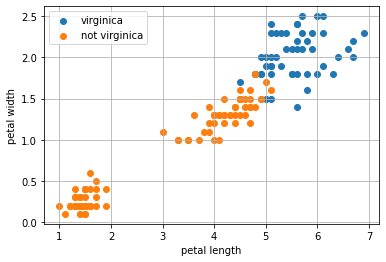

In [5]:
# 샘플들을 2차원 평면(x: petal length, y: petal width, color: 품종)에 시각화
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='virginica')      # X[:50, 0]
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='not virginica')  # X[50:, 0]

plt.legend()
plt.grid()
plt.xlabel('petal length')
plt.ylabel('petal width')

In [6]:
# 모델 생성
svc = LinearSVC(random_state=1, C=1e3)
# 모델 훈련
svc.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [7]:
b0, (b1, b2) = svc.intercept_[0], svc.coef_[0]
b0, b1, b2  # b0 + b1 * x1 + b2 * x2 = 0: 결정 경계 직선(평면)의 방정식

(-11.042323015598502, 1.4941447587355887, 3.0322307819039334)

In [8]:
def plot_decision_boundary(model, x_min, x_max):
    # 결정 경계면을 그리기 위한 x 좌표
    x_pts = np.linspace(x_min, x_max, 50)
    # 모델에서 찾은 평면의 방정식
    b0, (b1, b2) = model.intercept_[0], model.coef_[0]
    y_pts = (-1/b2) * (b0 + b1 * x_pts)
    plt.plot(x_pts, y_pts, 'r-')  # 결정 경계면(decision boundary)
    plt.plot(x_pts, y_pts + (1/b2), 'k-')  # SV가 놓여 있는 평면
    plt.plot(x_pts, y_pts - (1/b2), 'k-')  # SV가 놓여 있는 평면

    # 샘플들 시각화
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label='virginica')      # X[:50, 0]
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label='not virginica')  # X[50:, 0]

    plt.legend()
    plt.grid()
    plt.xlabel('petal length')
    plt.ylabel('petal width')

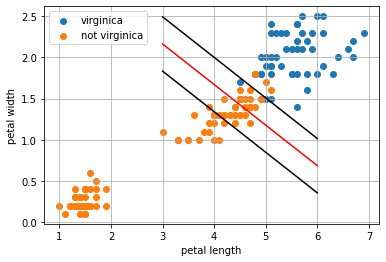

In [9]:
plot_decision_boundary(svc, x_min=3, x_max=6)

* 규제와 결정 경계면 관계
  * `C = 1 / alpha`
  * C가 크면, alpha가 작아짐 -> 규제가 작아짐 -> 훈련 셋에 더 많이 fitting: overfitting 가능성 커짐.
  * C가 작으면, alpha는 커짐 -> 규제가 커짐 -> 훈련 셋의 오차(손실/비용)가 커짐: 모델은 훈련되지 않은 셋에 더 잘 일반화될 수 있음.

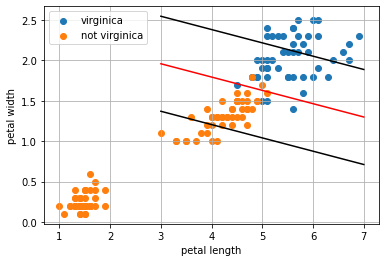

In [10]:
svc2 = LinearSVC(C=1.0, random_state=1)
svc2.fit(X, y)
plot_decision_boundary(svc2, x_min=3, x_max=7)

* iris 데이터 셋을 사용, multi-class 분류.
* 테스트 셋은 전체 샘플 크기의 20%를 사용. 계층적 분리(stratified split)을 사용.
* LinearSVC, 특성 스케일링(표준화)를 사용한 LinearSVC, 특성 스케일링을 사용한 SVC(kernel='linear'), 특성 스케일링을 사용한 SGDClassifier를 비교하세요.
  * 훈련 셋의 classification report, 테스트 셋의 classification report

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
def train_test_report(X, y, classifier, scaler=None):
    # 데이터(X)와 레이블(y)을 훈련 셋과 테스트 셋으로 계층적 분리.
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
    # 모델 생성
    if scaler: # 특성 변환기가 있는 경우
        model = Pipeline([('scaler', scaler),
                          ('clf', classifier)])
    else:  # scaler가 없는 경우
        model = classifier

    # 모델 훈련(훈련 셋에 모델을 fitting)
    model.fit(X_train, y_train)

    # 훈련 셋 평가 리포트
    sets = [('Train Set', X_train, y_train),
            ('Test Set', X_test, y_test)]
    for title, X, y in sets:
        print(f'===== {title} =====')
        y_preds = model.predict(X)
        conf_mat = confusion_matrix(y, y_preds)
        print(conf_mat)
        report = classification_report(y, y_preds)
        print(report)

In [13]:
X, y = load_iris(return_X_y=True)

In [14]:
lin_svc = LinearSVC(random_state=1)
train_test_report(X, y, lin_svc)

===== Train Set =====
[[40  0  0]
 [ 0 38  2]
 [ 0  1 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.95      0.96        40
           2       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

===== Test Set =====
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [15]:
from sklearn.preprocessing import StandardScaler

In [17]:
lin_svc = LinearSVC(random_state=1)
std_scaler = StandardScaler()
train_test_report(X, y, lin_svc, std_scaler)

===== Train Set =====
[[40  0  0]
 [ 0 37  3]
 [ 0  3 37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.93      0.93        40
           2       0.93      0.93      0.93        40

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

===== Test Set =====
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [18]:
from sklearn.svm import SVC

In [19]:
svc_clf = SVC(kernel='linear', random_state=1)
train_test_report(X, y, svc_clf, std_scaler)

===== Train Set =====
[[40  0  0]
 [ 0 37  3]
 [ 0  1 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.93      0.95        40
           2       0.93      0.97      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

===== Test Set =====
[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [20]:
from sklearn.linear_model import SGDClassifier

In [21]:
sgd_clf = SGDClassifier(random_state=1)
train_test_report(X, y, sgd_clf, std_scaler)

===== Train Set =====
[[39  1  0]
 [ 0 37  3]
 [ 0  6 34]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.84      0.93      0.88        40
           2       0.92      0.85      0.88        40

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120

===== Test Set =====
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



# 비선형 SVM(Support Vector Machine)

In [22]:
# 데이터 셋 준비
from sklearn.datasets import make_moons

In [45]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
X.shape, y.shape
# X: 2개의 특성(변수, 컬럼)을 갖는 100개 샘플(row)
# y: 레이블

((100, 2), (100,))

In [46]:
X[:5]

array([[ 1.61383833, -0.49115086],
       [ 0.08984723,  0.50439056],
       [ 0.74721047, -0.36911116],
       [-1.10174514,  0.23685641],
       [-0.72871455,  0.14652347]])

In [25]:
y[:5]

array([1, 1, 1, 0, 0])

In [47]:
# 샘플 시각화
def plot_datasets(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1])
    plt.scatter(X[y == 1, 0], X[y == 1, 1])
    plt.grid()
    plt.xlabel('x1')
    plt.ylabel('x2')

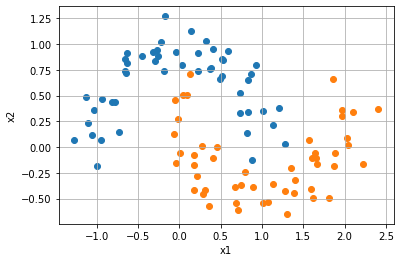

In [48]:
plot_datasets(X, y)

In [33]:
# 비선형 SVM: 다차항 추가, 특성 스케일링(표준화), LinearSVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [49]:
poly_lin_svm = Pipeline([
        ('poly_features', PolynomialFeatures(degree=3)),
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(random_state=42))
])

poly_lin_svm.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=42,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [56]:
def plot_predictions(classifier):
    # 예측값들을 계산할 x1-x2 평면 상의 점들
    x1 = np.linspace(start=-1.5, stop=2.5, num=100)  # (100,) 모양의 1d array
    x2 = np.linspace(start=-1.0, stop=1.5, num=100)  # (100,) 모양의 1d array
    X1, X2 = np.meshgrid(x1, x2)  # X1, X2는 (100, 100) 모양의 2d array
    X_test = np.c_[X1.ravel(), X2.ravel()]  # (100*100, 2) 모양의 2d array -> 격자(grid)의 점들
    y_pred = classifier.predict(X_test).reshape(X1.shape)
    plt.contourf(X1, X2, y_pred, alpha=0.2)


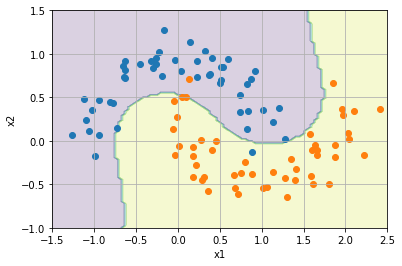

In [57]:
plot_predictions(poly_lin_svm)
plot_datasets(X, y)

In [60]:
poly_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='poly', degree=3, coef0=1.0, random_state=42))
])
# SVC 하이퍼 파라미터 coef0:
#   고차항에게 어떤 정도의 가중치(중요도)를 줄 것인지를 결저하는 파라미터.
#   coef0가 작을 수록 저차항이 중요해지고, coef0가 클 수록 고차항이 중요해짐.
#   coef0가 작을 수록 직선에 가까워짐. 마진 오차가 커짐. overfitting이 줄어듬.

poly_svm.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=42, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

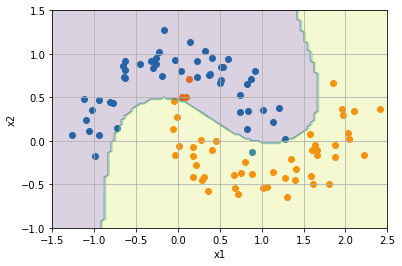

In [61]:
plot_datasets(X, y)
plot_predictions(poly_svm)

degree=3, coef0=1


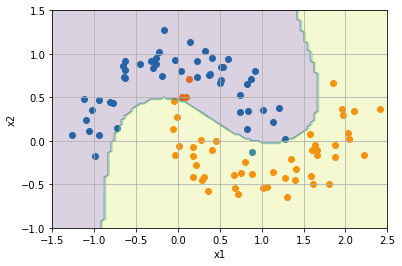

degree=10, coef0=1


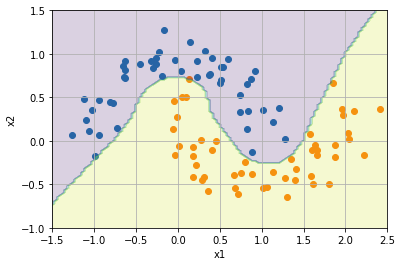

degree=10, coef0=100


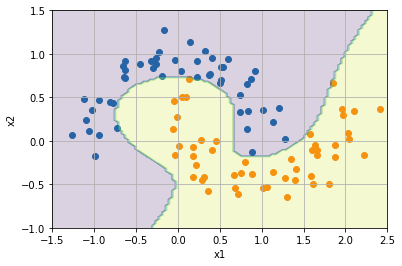

In [62]:
# SVC에서 (degree, coef0) 조합 실험: (3, 1), (10, 1), (10, 100)
degrees_coef0s = [(3, 1), (10, 1), (10, 100)]
for deg, coef in degrees_coef0s:
    print(f'degree={deg}, coef0={coef}')
    clf = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(kernel='poly', degree=deg, coef0=coef, random_state=42))
    ])
    clf.fit(X, y)
    plot_datasets(X, y)
    plot_predictions(clf)
    plt.show()

Gaussian RBF Kernel with gamma=0.1, C=0.001


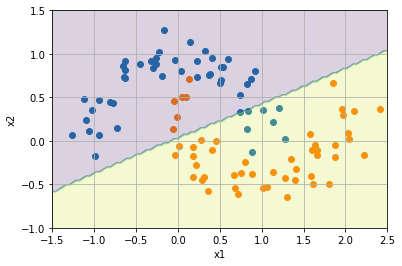

Gaussian RBF Kernel with gamma=0.1, C=1000.0


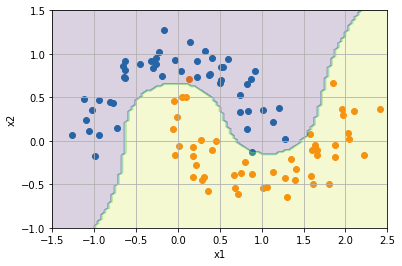

Gaussian RBF Kernel with gamma=5, C=0.001


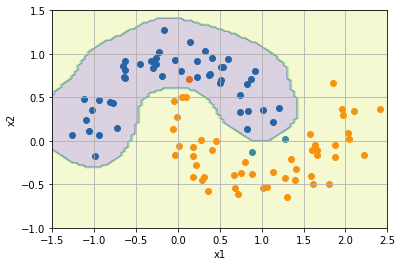

Gaussian RBF Kernel with gamma=5, C=1000.0


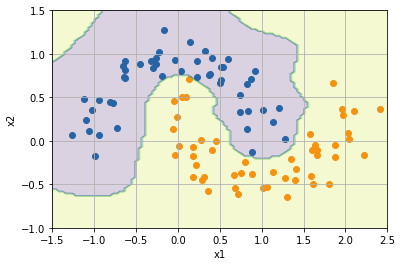

In [64]:
# Gaussian RBF 커널을 이용한 SVM 분류
# kernel='rbf'인 경우:
#   gamma가 작을 수록(0에 가까울 수록) 직선에 가까운 경계면
#   gamma가 클 수록 모델에 overfitting이 되는 경계면

# C: l2 규제의 강도 (C = 1/alpha)
#   C가 작을 수록 직선에 가까운 경계면(overfitting이 줄어듬)
#   C가 클 수록 모델에 overfitting이 되는 경계면.

gammas_cs = [(0.1, 1e-3), (0.1, 1e3), (5, 1e-3), (5, 1e3)]
for g, c in gammas_cs:
    print(f'Gaussian RBF Kernel with gamma={g}, C={c}')
    clf = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(kernel='rbf', gamma=g, C=c, random_state=42))
    ])
    clf.fit(X, y)
    plot_datasets(X, y)
    plot_predictions(clf)
    plt.show()

* SVM 분류
    * LinearSVC 먼저 시도
    * SVC에서 kernel 바꿔가면 시도